# Optuna Hyperparameter Search (Part 1)

In this notebook we use optuna LightGBM integration with a pruner to perform a hyperparameter search. Our first run of this notebook shows that learning rate is by far the most "important" parameter so we fix our learning rate to test out the other possible parameters.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_TREES = 15000
EARLY_STOP = 200
NUM_TRIALS = 50
TRIAL_FOLDS = 3

In [2]:
# General imports
import numpy as np
import pandas as pd
from IPython.display import Image
import pyarrow
import time
import gc

# Model and evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization import plot_param_importances, plot_parallel_coordinate
from optuna.pruners import MedianPruner, PercentilePruner

# Hide warnings (makes optuna output easier to parse)
import warnings
warnings.filterwarnings('ignore')

# Preparing the Data

In [3]:
# Generate training and holdout set
train = pd.read_feather("../data/train.feather")

# Holdout set for testing our models
train, holdout = train_test_split(
    train,
    test_size = 0.5,
    shuffle = True,
    stratify = train['target'],
    random_state = RANDOM_SEED,
)

train.reset_index(drop = True, inplace = True)
holdout.reset_index(drop = True, inplace = True)

# Save features and categorical features
features = [x for x in train.columns if x not in ['id','target']]
categorical_features = [x for x in features if train[x].dtype.name.startswith("int")]

gc.collect()

0

# Scoring Function

In [4]:
# Default Model Parameters
default_params = dict(
    random_state = RANDOM_SEED,
    n_estimators = NUM_TREES,
)

In [5]:
def score_lightgbm(trial = None, model_params = {}, fit_params = {}):
    
    # Store the holdout predictions
    scores = np.zeros(TRIAL_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = TRIAL_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['target'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        
        start = time.time()
        
        # Define Model
        model = LGBMClassifier(**default_params, **model_params)
        gc.collect()
        
        model.fit(
            X_train, y_train,
            verbose = 0,
            eval_set = [(X_valid, y_valid)],
            eval_metric = "auc",
            early_stopping_rounds = EARLY_STOP,
            **fit_params
        )
        fold_preds = model.predict_proba(holdout[features])[:, 1]
        valid_preds = model.predict_proba(X_valid)[:, 1]
        scores[fold] = roc_auc_score(holdout['target'], fold_preds)
        
        end = time.time()
        print(f'Fold {fold} done in {round(end - start, 1)}s.')
        if trial:
            # Use pruning on fold AUC
            trial.report(
                value = roc_auc_score(y_valid, valid_preds),
                step = fold
            )
            # prune slow trials and bad fold AUCs
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        time.sleep(0.5)
        
        # If it takes too long return fold AUC
        if round(end - start, 1) > 480:
            return scores.sum() / (fold + 1)
        
    return scores.mean()

## Categorical Features

We check if explicitly specifying the categorical features makes a difference in accuracy or training speed.

In [6]:
# Default settings
score_lightgbm(
    fit_params = dict(categorical_feature = 'auto')
)

Fold 0 done in 71.3s.
Fold 1 done in 61.1s.
Fold 2 done in 57.3s.


0.8541729481182679

In [7]:
# Explicitly specify categorical features
score_lightgbm(
    fit_params = dict(categorical_feature = categorical_features)
)

Fold 0 done in 59.1s.
Fold 1 done in 56.9s.
Fold 2 done in 58.3s.


0.8541729481182679

We see that specifying the categorical features doesn't make a notable difference in accuracy or training speed.

# Hyperparameter Search

To tweak the pruner consider adding/adjusting the following keyword arguments:

* `n_startup_trials` - number of trials (models trained) before pruning starts
* `n_warmup_steps` - number of iterations before pruning checks
* `interval_steps` - number of iterations between pruning checks
* `n_min_trials` - skip pruning check if too few trials

In [8]:
# Pruner lower percentile of trials
pruner = PercentilePruner(
    percentile = 80,
    n_startup_trials = 5,
    n_warmup_steps = 0,
    interval_steps = 1,
    n_min_trials = 5,
)

In [9]:
def parameter_search(trials):
    
    # Optuna objective function
    def objective(trial):
        model_params = dict( 
            # default -1
            max_depth = trial.suggest_int(
                "max_depth", 2, 10
            ), 
            # default 0.1
            learning_rate = trial.suggest_categorical(
                "learning_rate", [0.01]
            ),
            # default 0
            min_split_gain = trial.suggest_loguniform(
                "min_split_gain", 1e-10, 10
            ), 
            # default 1e-3
            min_child_weight = trial.suggest_loguniform(
                "min_child_weight", 1e-10, 100
            ),
            # default 20
            min_child_samples = trial.suggest_int(
                "min_child_samples", 10, 10000, 10
            ), 
            # default 1
            subsample = trial.suggest_discrete_uniform(
                "subsample", 0.5, 1.0, 0.01
            ),
            # default 0
            subsample_freq = trial.suggest_int(
                "subsample_freq",  0, 10
            ),
            # default 1
            colsample_bytree = trial.suggest_discrete_uniform(
                "colsample_bytree",  0.1, 1.0, 0.01
            ),
            # default 0
            reg_lambda = trial.suggest_loguniform(
                "reg_lambda", 1e-10, 100
            ),
            # default 0
            reg_alpha = trial.suggest_loguniform(
                "reg_alpha", 1e-10, 100
            ),
            # default 10
            cat_smooth = trial.suggest_loguniform(
                "cat_smooth", 1e-10, 100
            ),
            # default 10
            cat_l2 = trial.suggest_loguniform(
                "cat_l2", 1e-10, 100
            ),
            
        )
    
        # num_leaves should be less than 2^max_depth
        model_params['num_leaves'] = trial.suggest_int(
            'num_leaves', 2, 2**model_params['max_depth']-1
        )
        
        #fit_params = dict(
        #    callbacks = [LightGBMPruningCallback(trial, "auc")],
        #)
        
        return score_lightgbm(
            trial = trial,
            model_params = model_params
        )
    
    
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study = optuna.create_study(
        pruner = pruner,
        direction = "maximize"
    )
    # high auc from previous notebook run
    study.enqueue_trial({
        'max_depth': 8, 
        #'learning_rate': 0.010138272553606617, original
        'learning_rate': 0.01, 
        'min_split_gain': 0.18468002957592108, 
        'min_child_weight': 1.839038499751012e-09, 
        'min_child_samples': 8420, 
        'subsample': 0.59, 
        'subsample_freq': 0, 
        'colsample_bylevel': 0.22, 
        'reg_lambda': 4.289479936233822e-10, 
        'reg_alpha': 1.0096021385139975e-07, 
        'cat_smooth': 1.1437149718387542e-05, 
        'cat_l2': 0.00012504779932670876, 
        'num_leaves': 137
    })
    study.optimize(objective, n_trials=trials)
    return study

In [10]:
# Hide output
study = parameter_search(NUM_TRIALS)

[I 2021-10-24 12:36:19,194] A new study created in memory with name: no-name-d6d08ecb-5938-4eec-aafa-6fa0b31eeb05
[D 2021-10-24 12:36:19,197] Trial 0 popped from the trial queue.


Fold 0 done in 343.3s.
Fold 1 done in 338.8s.
Fold 2 done in 302.9s.


[I 2021-10-24 12:52:47,560] Trial 0 finished with value: 0.8565316285333782 and parameters: {'max_depth': 8, 'learning_rate': 0.01, 'min_split_gain': 0.18468002957592108, 'min_child_weight': 1.839038499751012e-09, 'min_child_samples': 8420, 'subsample': 0.59, 'subsample_freq': 0, 'colsample_bytree': 0.41000000000000003, 'reg_lambda': 4.289479936233822e-10, 'reg_alpha': 1.0096021385139975e-07, 'cat_smooth': 1.1437149718387542e-05, 'cat_l2': 0.00012504779932670876, 'num_leaves': 137}. Best is trial 0 with value: 0.8565316285333782.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 0 done in 392.0s.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 1 done in 440.8s.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 2 done in 365.3s.


[I 2021-10-24 13:12:49,206] Trial 1 finished with value: 0.8563072054573467 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 0.0002289937891975488, 'min_child_weight': 0.0001795670668648115, 'min_child_samples': 8240, 'subsample': 0.78, 'subsample_freq': 6, 'colsample_bytree': 0.91, 'reg_lambda': 1.4182337616411738e-05, 'reg_alpha': 0.00015288644805450493, 'cat_smooth': 0.01175677555345737, 'cat_l2': 0.08840670346545175, 'num_leaves': 31}. Best is trial 0 with value: 0.8565316285333782.


Fold 0 done in 537.6s.


[I 2021-10-24 13:21:48,024] Trial 2 finished with value: 0.855903617092043 and parameters: {'max_depth': 9, 'learning_rate': 0.01, 'min_split_gain': 0.1050068374622758, 'min_child_weight': 0.02654733865114512, 'min_child_samples': 6540, 'subsample': 0.99, 'subsample_freq': 7, 'colsample_bytree': 0.91, 'reg_lambda': 78.20471098180727, 'reg_alpha': 5.662722654657448e-07, 'cat_smooth': 2.9080835110098198, 'cat_l2': 0.16534532556169884, 'num_leaves': 302}. Best is trial 0 with value: 0.8565316285333782.


Fold 0 done in 178.3s.
Fold 1 done in 178.9s.
Fold 2 done in 171.8s.


[I 2021-10-24 13:30:40,500] Trial 3 finished with value: 0.8567617962281703 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 2.3898913428584182e-08, 'min_child_weight': 0.0071606375423038755, 'min_child_samples': 1720, 'subsample': 0.54, 'subsample_freq': 2, 'colsample_bytree': 0.21000000000000002, 'reg_lambda': 0.032374306520872066, 'reg_alpha': 0.0037516426604376476, 'cat_smooth': 5.090909013690385e-06, 'cat_l2': 4.747594780982746e-05, 'num_leaves': 21}. Best is trial 3 with value: 0.8567617962281703.


Fold 0 done in 262.1s.
Fold 1 done in 306.9s.
Fold 2 done in 274.2s.


[I 2021-10-24 13:44:47,063] Trial 4 finished with value: 0.8562864784617643 and parameters: {'max_depth': 10, 'learning_rate': 0.01, 'min_split_gain': 9.075345264446909e-10, 'min_child_weight': 0.005711772002724316, 'min_child_samples': 6800, 'subsample': 0.5, 'subsample_freq': 4, 'colsample_bytree': 0.61, 'reg_lambda': 1.0184216338151988, 'reg_alpha': 33.246861921384586, 'cat_smooth': 2.685605247993885e-07, 'cat_l2': 2.216193611521538e-10, 'num_leaves': 691}. Best is trial 3 with value: 0.8567617962281703.


Fold 0 done in 394.3s.
Fold 1 done in 391.1s.
Fold 2 done in 358.7s.


[I 2021-10-24 14:03:54,544] Trial 5 finished with value: 0.8564384580720188 and parameters: {'max_depth': 7, 'learning_rate': 0.01, 'min_split_gain': 1.1651038422881453e-09, 'min_child_weight': 1.6676129876308485e-07, 'min_child_samples': 10000, 'subsample': 0.81, 'subsample_freq': 2, 'colsample_bytree': 0.73, 'reg_lambda': 1.4605465578998518e-10, 'reg_alpha': 0.00604397814714253, 'cat_smooth': 2.4135933768066415e-07, 'cat_l2': 0.00015931343815492454, 'num_leaves': 97}. Best is trial 3 with value: 0.8567617962281703.


Fold 0 done in 256.5s.
Fold 1 done in 286.2s.
Fold 2 done in 254.5s.


[I 2021-10-24 14:17:15,053] Trial 6 finished with value: 0.8567136153133164 and parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_split_gain': 0.0032780581637828093, 'min_child_weight': 84.0113110777526, 'min_child_samples': 6410, 'subsample': 0.61, 'subsample_freq': 5, 'colsample_bytree': 0.38, 'reg_lambda': 0.03232191324895105, 'reg_alpha': 0.18803451154082704, 'cat_smooth': 0.028822577971880935, 'cat_l2': 5.371479331891687e-05, 'num_leaves': 7}. Best is trial 3 with value: 0.8567617962281703.
[I 2021-10-24 14:22:34,779] Trial 7 pruned. 


Fold 0 done in 319.1s.
Fold 0 done in 330.4s.
Fold 1 done in 337.9s.
Fold 2 done in 309.3s.


[I 2021-10-24 14:38:55,712] Trial 8 finished with value: 0.8565106454468868 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 1.4662205548453919e-06, 'min_child_weight': 23.34450062217578, 'min_child_samples': 3190, 'subsample': 0.64, 'subsample_freq': 5, 'colsample_bytree': 0.74, 'reg_lambda': 9.521832997652113e-08, 'reg_alpha': 8.799811426878007e-08, 'cat_smooth': 2.7230148407279836e-07, 'cat_l2': 1.141614449460356e-10, 'num_leaves': 16}. Best is trial 3 with value: 0.8567617962281703.
[I 2021-10-24 14:39:05,354] Trial 9 pruned. 


Fold 0 done in 9.0s.
Fold 0 done in 195.5s.
Fold 1 done in 209.2s.
Fold 2 done in 200.5s.


[I 2021-10-24 14:49:13,970] Trial 10 finished with value: 0.8565884743524185 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 1.4262432056323698e-07, 'min_child_weight': 0.3275017989267595, 'min_child_samples': 150, 'subsample': 0.94, 'subsample_freq': 0, 'colsample_bytree': 0.2, 'reg_lambda': 0.0014552178505536709, 'reg_alpha': 0.00019803328545528383, 'cat_smooth': 8.16805860296165e-05, 'cat_l2': 1.516372205405077e-07, 'num_leaves': 21}. Best is trial 3 with value: 0.8567617962281703.
[I 2021-10-24 14:54:19,358] Trial 11 pruned. 


Fold 0 done in 304.7s.
Fold 0 done in 234.3s.
Fold 1 done in 234.7s.
Fold 2 done in 226.7s.


[I 2021-10-24 15:05:58,585] Trial 12 finished with value: 0.8567244860755868 and parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_split_gain': 5.9555449267762155, 'min_child_weight': 0.9597969401289757, 'min_child_samples': 2310, 'subsample': 0.59, 'subsample_freq': 2, 'colsample_bytree': 0.36, 'reg_lambda': 0.05507276209049674, 'reg_alpha': 0.05455311784228901, 'cat_smooth': 76.132418609574, 'cat_l2': 4.440570611786606e-07, 'num_leaves': 7}. Best is trial 3 with value: 0.8567617962281703.


Fold 0 done in 234.9s.
Fold 1 done in 235.7s.
Fold 2 done in 208.0s.


[I 2021-10-24 15:17:20,594] Trial 13 finished with value: 0.8567952141210764 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 2.0123954658950836, 'min_child_weight': 0.6695967470200936, 'min_child_samples': 2170, 'subsample': 0.7, 'subsample_freq': 2, 'colsample_bytree': 0.26, 'reg_lambda': 3.7180026157708655e-05, 'reg_alpha': 8.433165259902195e-10, 'cat_smooth': 74.87977856127084, 'cat_l2': 3.8848308021697336e-07, 'num_leaves': 8}. Best is trial 13 with value: 0.8567952141210764.


Fold 0 done in 222.5s.
Fold 1 done in 247.8s.
Fold 2 done in 219.6s.


[I 2021-10-24 15:28:53,953] Trial 14 finished with value: 0.8568366305762058 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 6.3727901357436895e-06, 'min_child_weight': 0.002234945539067982, 'min_child_samples': 2020, 'subsample': 0.72, 'subsample_freq': 2, 'colsample_bytree': 0.24000000000000002, 'reg_lambda': 5.5477360524392205e-05, 'reg_alpha': 1.4390688467326071e-10, 'cat_smooth': 0.00025991255142908187, 'cat_l2': 9.299194506874969e-07, 'num_leaves': 9}. Best is trial 14 with value: 0.8568366305762058.


Fold 0 done in 322.8s.
Fold 1 done in 327.9s.
Fold 2 done in 286.8s.


[I 2021-10-24 15:44:35,019] Trial 15 finished with value: 0.856735235104409 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 6.101569191703784e-06, 'min_child_weight': 0.4145309802807301, 'min_child_samples': 4570, 'subsample': 0.72, 'subsample_freq': 1, 'colsample_bytree': 0.5, 'reg_lambda': 1.4508959537653535e-05, 'reg_alpha': 2.479595537834115e-10, 'cat_smooth': 56.54723211332502, 'cat_l2': 1.5999311944914043e-08, 'num_leaves': 9}. Best is trial 14 with value: 0.8568366305762058.


Fold 0 done in 246.3s.
Fold 1 done in 243.4s.
Fold 2 done in 222.4s.


[I 2021-10-24 15:56:30,449] Trial 16 finished with value: 0.8568496975432179 and parameters: {'max_depth': 6, 'learning_rate': 0.01, 'min_split_gain': 0.7624499003351858, 'min_child_weight': 0.0008262510967999328, 'min_child_samples': 3170, 'subsample': 0.86, 'subsample_freq': 3, 'colsample_bytree': 0.24000000000000002, 'reg_lambda': 0.00018513239537346443, 'reg_alpha': 2.897981474275491e-10, 'cat_smooth': 0.0006369811869977466, 'cat_l2': 1.6177560603036794e-06, 'num_leaves': 13}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 185.3s.


[I 2021-10-24 16:02:32,136] Trial 17 pruned. 


Fold 1 done in 174.6s.
Fold 0 done in 318.2s.
Fold 1 done in 325.2s.
Fold 2 done in 329.5s.


[I 2021-10-24 16:18:48,510] Trial 18 finished with value: 0.8566062723745671 and parameters: {'max_depth': 6, 'learning_rate': 0.01, 'min_split_gain': 2.8336900681863315e-05, 'min_child_weight': 0.00046279741560154686, 'min_child_samples': 5410, 'subsample': 0.9, 'subsample_freq': 7, 'colsample_bytree': 0.51, 'reg_lambda': 0.0005917764699162916, 'reg_alpha': 1.0383025671893764e-10, 'cat_smooth': 0.003330694549652803, 'cat_l2': 4.715105740598697e-09, 'num_leaves': 15}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 239.9s.
Fold 1 done in 251.0s.
Fold 2 done in 221.0s.


[I 2021-10-24 16:30:43,866] Trial 19 finished with value: 0.8567782616837265 and parameters: {'max_depth': 6, 'learning_rate': 0.01, 'min_split_gain': 7.184354963565723e-07, 'min_child_weight': 3.2616138838369835e-08, 'min_child_samples': 1040, 'subsample': 0.8500000000000001, 'subsample_freq': 4, 'colsample_bytree': 0.25, 'reg_lambda': 2.585234527383447e-06, 'reg_alpha': 6.1465545833673e-06, 'cat_smooth': 0.00013804305808718368, 'cat_l2': 0.004644772394163085, 'num_leaves': 15}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 317.6s.
Fold 1 done in 334.9s.
Fold 2 done in 297.5s.


[I 2021-10-24 16:46:37,264] Trial 20 finished with value: 0.856639084496234 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 3.2516972546763715e-05, 'min_child_weight': 0.0008304286585963838, 'min_child_samples': 5340, 'subsample': 0.89, 'subsample_freq': 3, 'colsample_bytree': 0.45000000000000007, 'reg_lambda': 0.0009483537339270746, 'reg_alpha': 9.613005799997738e-09, 'cat_smooth': 0.18341799068179304, 'cat_l2': 5.833053638847029e-06, 'num_leaves': 11}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 238.0s.
Fold 1 done in 230.8s.
Fold 2 done in 195.4s.


[I 2021-10-24 16:57:44,913] Trial 21 finished with value: 0.856827041271146 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 6.622613569592492, 'min_child_weight': 0.055864997760601394, 'min_child_samples': 2500, 'subsample': 0.71, 'subsample_freq': 1, 'colsample_bytree': 0.29000000000000004, 'reg_lambda': 0.0001053860681776111, 'reg_alpha': 1.7668792340472503e-09, 'cat_smooth': 1.1437323932700356, 'cat_l2': 5.3604716465060225e-09, 'num_leaves': 9}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 282.4s.
Fold 1 done in 280.0s.
Fold 2 done in 263.8s.


[I 2021-10-24 17:11:34,571] Trial 22 finished with value: 0.8567457127569748 and parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_split_gain': 0.5408564292943224, 'min_child_weight': 0.042773697259870694, 'min_child_samples': 3020, 'subsample': 0.69, 'subsample_freq': 1, 'colsample_bytree': 0.30000000000000004, 'reg_lambda': 0.0001899544114788025, 'reg_alpha': 3.6272039202199276e-09, 'cat_smooth': 0.8420324441118983, 'cat_l2': 3.619559521188312e-09, 'num_leaves': 6}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 203.6s.
Fold 1 done in 179.3s.
Fold 2 done in 182.7s.


[I 2021-10-24 17:21:03,568] Trial 23 finished with value: 0.8567556758863878 and parameters: {'max_depth': 7, 'learning_rate': 0.01, 'min_split_gain': 0.015126511778195498, 'min_child_weight': 1.3221733316982319e-06, 'min_child_samples': 2730, 'subsample': 0.76, 'subsample_freq': 1, 'colsample_bytree': 0.18, 'reg_lambda': 5.969490782689857e-07, 'reg_alpha': 1.018785521484617e-09, 'cat_smooth': 0.00032596586904044773, 'cat_l2': 4.492466462915828e-06, 'num_leaves': 36}. Best is trial 16 with value: 0.8568496975432179.
[I 2021-10-24 17:24:50,999] Trial 24 pruned. 


Fold 0 done in 226.8s.


[I 2021-10-24 17:29:09,790] Trial 25 pruned. 


Fold 0 done in 258.1s.
Fold 0 done in 212.7s.
Fold 1 done in 230.1s.
Fold 2 done in 198.6s.


[I 2021-10-24 17:39:54,661] Trial 26 finished with value: 0.8566632843537644 and parameters: {'max_depth': 3, 'learning_rate': 0.01, 'min_split_gain': 0.0004452533222819346, 'min_child_weight': 5.459858763458679, 'min_child_samples': 660, 'subsample': 0.67, 'subsample_freq': 1, 'colsample_bytree': 0.15000000000000002, 'reg_lambda': 0.0001227750178071753, 'reg_alpha': 5.241174584564029e-06, 'cat_smooth': 0.0009349263589584192, 'cat_l2': 0.0016144469691671698, 'num_leaves': 6}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 196.7s.
Fold 1 done in 205.7s.
Fold 2 done in 189.9s.


[I 2021-10-24 17:49:50,354] Trial 27 finished with value: 0.8567886916775805 and parameters: {'max_depth': 6, 'learning_rate': 0.01, 'min_split_gain': 1.778206336370785, 'min_child_weight': 0.06013501084862506, 'min_child_samples': 2000, 'subsample': 0.8, 'subsample_freq': 3, 'colsample_bytree': 0.25, 'reg_lambda': 3.846394165160828e-06, 'reg_alpha': 1.143795623117715e-09, 'cat_smooth': 1.1915804838160526e-08, 'cat_l2': 4.531665412393293e-08, 'num_leaves': 20}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 319.0s.
Fold 1 done in 320.5s.
Fold 2 done in 306.5s.


[I 2021-10-24 18:05:39,872] Trial 28 finished with value: 0.8566604929271272 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 1.070580811243283e-08, 'min_child_weight': 0.00010587341673017128, 'min_child_samples': 3860, 'subsample': 0.86, 'subsample_freq': 4, 'colsample_bytree': 0.44000000000000006, 'reg_lambda': 8.81082429019019e-05, 'reg_alpha': 3.6889711462518237e-08, 'cat_smooth': 1.970352778221438e-05, 'cat_l2': 1.3252557492949074e-06, 'num_leaves': 10}. Best is trial 16 with value: 0.8568496975432179.
[I 2021-10-24 18:10:58,826] Trial 29 pruned. 


Fold 0 done in 318.3s.
Fold 0 done in 331.9s.


[I 2021-10-24 18:22:33,877] Trial 30 pruned. 


Fold 1 done in 361.3s.
Fold 0 done in 228.4s.
Fold 1 done in 239.7s.
Fold 2 done in 215.1s.


[I 2021-10-24 18:34:00,617] Trial 31 finished with value: 0.8568139982241565 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 2.469755636748821, 'min_child_weight': 7.3048770847214755, 'min_child_samples': 2410, 'subsample': 0.7, 'subsample_freq': 2, 'colsample_bytree': 0.28, 'reg_lambda': 1.668696972040079e-05, 'reg_alpha': 7.731097505645484e-10, 'cat_smooth': 16.551221599924602, 'cat_l2': 4.1919429174268276e-07, 'num_leaves': 9}. Best is trial 16 with value: 0.8568496975432179.
[I 2021-10-24 18:38:53,591] Trial 32 pruned. 


Fold 0 done in 292.3s.
Fold 0 done in 213.8s.
Fold 1 done in 220.6s.
Fold 2 done in 201.6s.


[I 2021-10-24 18:49:33,025] Trial 33 finished with value: 0.8568171079337611 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 0.09811476923706315, 'min_child_weight': 8.195089896592519, 'min_child_samples': 1550, 'subsample': 0.77, 'subsample_freq': 3, 'colsample_bytree': 0.22, 'reg_lambda': 0.0034168472741421285, 'reg_alpha': 3.666228468663268e-09, 'cat_smooth': 0.34715552008378403, 'cat_l2': 3.4294436827529745e-07, 'num_leaves': 13}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 206.5s.
Fold 1 done in 205.0s.
Fold 2 done in 184.6s.


[I 2021-10-24 18:59:32,609] Trial 34 finished with value: 0.8568162603969606 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 0.12712835270717693, 'min_child_weight': 0.12023672206137188, 'min_child_samples': 1490, 'subsample': 0.78, 'subsample_freq': 3, 'colsample_bytree': 0.18, 'reg_lambda': 0.005372430050326603, 'reg_alpha': 5.754832348362136e-09, 'cat_smooth': 0.3422614211292056, 'cat_l2': 1.679808665417236e-05, 'num_leaves': 13}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 187.5s.
Fold 1 done in 189.1s.
Fold 2 done in 167.7s.


[I 2021-10-24 19:08:40,235] Trial 35 finished with value: 0.8566219941227541 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 0.03369357503975801, 'min_child_weight': 0.0078030635763147015, 'min_child_samples': 1430, 'subsample': 0.78, 'subsample_freq': 6, 'colsample_bytree': 0.1, 'reg_lambda': 0.0003795832062857229, 'reg_alpha': 1.9220842467824916e-08, 'cat_smooth': 0.042893232467381845, 'cat_l2': 3.221331868961391e-08, 'num_leaves': 13}. Best is trial 16 with value: 0.8568496975432179.
[I 2021-10-24 19:15:53,621] Trial 36 pruned. 


Fold 0 done in 432.7s.
Fold 0 done in 187.3s.
Fold 1 done in 196.4s.
Fold 2 done in 171.6s.


[I 2021-10-24 19:25:12,320] Trial 37 finished with value: 0.8567637341073345 and parameters: {'max_depth': 7, 'learning_rate': 0.01, 'min_split_gain': 0.0008333101621362511, 'min_child_weight': 0.011535146632665772, 'min_child_samples': 1790, 'subsample': 0.74, 'subsample_freq': 4, 'colsample_bytree': 0.22, 'reg_lambda': 0.007079046090205588, 'reg_alpha': 3.9519999275253824e-05, 'cat_smooth': 1.2095368607893963e-06, 'cat_l2': 0.0006320383970014197, 'num_leaves': 29}. Best is trial 16 with value: 0.8568496975432179.
[I 2021-10-24 19:28:44,370] Trial 38 pruned. 


Fold 0 done in 211.4s.


[I 2021-10-24 19:31:39,126] Trial 39 pruned. 


Fold 0 done in 174.1s.
Fold 0 done in 277.4s.
Fold 1 done in 285.6s.
Fold 2 done in 265.2s.


[I 2021-10-24 19:45:30,728] Trial 40 finished with value: 0.8567480668125323 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 7.677924985446525e-06, 'min_child_weight': 0.14559791761875235, 'min_child_samples': 6010, 'subsample': 0.76, 'subsample_freq': 2, 'colsample_bytree': 0.4, 'reg_lambda': 6.463583974254451e-05, 'reg_alpha': 1.2716930091397456e-07, 'cat_smooth': 0.0006101933670553311, 'cat_l2': 1.157313139076524e-07, 'num_leaves': 14}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 189.7s.
Fold 1 done in 201.5s.
Fold 2 done in 182.1s.


[I 2021-10-24 19:55:07,467] Trial 41 finished with value: 0.8568116117365685 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 0.19747786879658968, 'min_child_weight': 0.08024945657392157, 'min_child_samples': 1460, 'subsample': 0.77, 'subsample_freq': 3, 'colsample_bytree': 0.18, 'reg_lambda': 0.004592898137326209, 'reg_alpha': 5.122671331183343e-09, 'cat_smooth': 0.20401309340286267, 'cat_l2': 3.638504811439816e-05, 'num_leaves': 13}. Best is trial 16 with value: 0.8568496975432179.
[I 2021-10-24 19:55:17,959] Trial 42 pruned. 


Fold 0 done in 9.9s.
Fold 0 done in 220.1s.
Fold 1 done in 211.8s.
Fold 2 done in 185.8s.


[I 2021-10-24 20:05:39,108] Trial 43 finished with value: 0.8568051160717648 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 0.0018524563086826182, 'min_child_weight': 0.0023896946167388288, 'min_child_samples': 1230, 'subsample': 0.6799999999999999, 'subsample_freq': 5, 'colsample_bytree': 0.23, 'reg_lambda': 0.0010996493183941932, 'reg_alpha': 2.539850974139884e-10, 'cat_smooth': 0.06993437591923579, 'cat_l2': 0.00011881417036457536, 'num_leaves': 11}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 268.3s.
Fold 1 done in 261.5s.
Fold 2 done in 250.8s.


[I 2021-10-24 20:18:43,162] Trial 44 finished with value: 0.8567387526970659 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'min_split_gain': 0.011253343280829019, 'min_child_weight': 3.4224138401222763, 'min_child_samples': 1880, 'subsample': 0.78, 'subsample_freq': 1, 'colsample_bytree': 0.33, 'reg_lambda': 0.00300319050767907, 'reg_alpha': 7.329169049206847e-09, 'cat_smooth': 0.46216181205591966, 'cat_l2': 7.096349520913455e-07, 'num_leaves': 12}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 200.9s.
Fold 1 done in 184.6s.
Fold 2 done in 179.0s.


[I 2021-10-24 20:28:11,215] Trial 45 finished with value: 0.8567997004346481 and parameters: {'max_depth': 5, 'learning_rate': 0.01, 'min_split_gain': 0.7649362606876722, 'min_child_weight': 0.2076528433759741, 'min_child_samples': 590, 'subsample': 0.65, 'subsample_freq': 4, 'colsample_bytree': 0.2, 'reg_lambda': 0.00027572740592419386, 'reg_alpha': 1.0705806851026484e-10, 'cat_smooth': 2.0383738941207716, 'cat_l2': 2.1112573956242216e-07, 'num_leaves': 14}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 203.7s.
Fold 1 done in 233.0s.
Fold 2 done in 197.5s.


[I 2021-10-24 20:38:48,938] Trial 46 finished with value: 0.8567814990094518 and parameters: {'max_depth': 7, 'learning_rate': 0.01, 'min_split_gain': 0.12123684006016956, 'min_child_weight': 19.25799774777725, 'min_child_samples': 3490, 'subsample': 0.87, 'subsample_freq': 3, 'colsample_bytree': 0.22, 'reg_lambda': 0.03849711625604168, 'reg_alpha': 2.4243410847320957e-09, 'cat_smooth': 0.006480431099609149, 'cat_l2': 67.1097468468325, 'num_leaves': 28}. Best is trial 16 with value: 0.8568496975432179.


Fold 0 done in 205.2s.


[I 2021-10-24 20:45:47,591] Trial 47 pruned. 


Fold 1 done in 211.7s.


[I 2021-10-24 20:51:01,325] Trial 48 pruned. 


Fold 0 done in 313.1s.


[I 2021-10-24 20:56:54,241] Trial 49 pruned. 


Fold 0 done in 352.3s.


## 1. Best Parameters

In [11]:
print("Best Parameters:", study.best_params)

Best Parameters: {'max_depth': 6, 'learning_rate': 0.01, 'min_split_gain': 0.7624499003351858, 'min_child_weight': 0.0008262510967999328, 'min_child_samples': 3170, 'subsample': 0.86, 'subsample_freq': 3, 'colsample_bytree': 0.24000000000000002, 'reg_lambda': 0.00018513239537346443, 'reg_alpha': 2.897981474275491e-10, 'cat_smooth': 0.0006369811869977466, 'cat_l2': 1.6177560603036794e-06, 'num_leaves': 13}


## 2. Parameter Importances

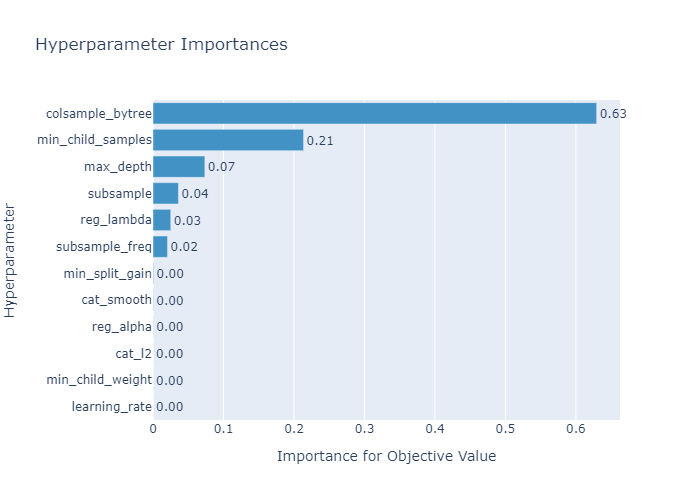

In [12]:
fig = plot_param_importances(study)
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

## 3. Parallel Coordinate Plots

In [19]:
# Interative version (won't work on github)
fig = plot_parallel_coordinate(
    study, 
    params=['min_child_samples', 'subsample', 'subsample_freq',
            'colsample_bytree', 'reg_lambda']
)
fig.show()

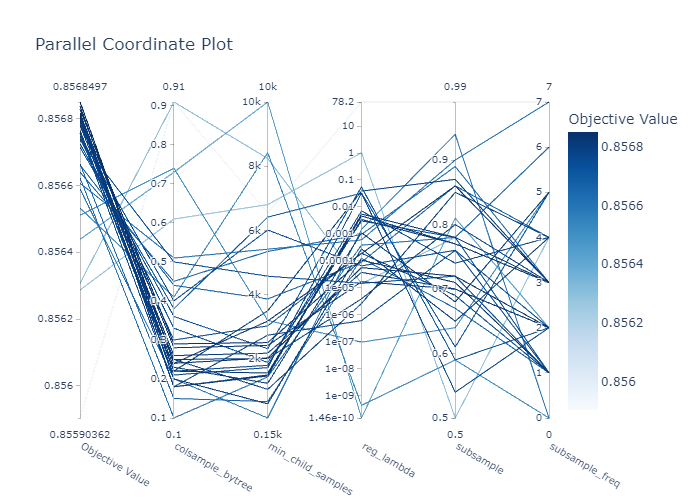

In [20]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

In [15]:
# Interative version (won't work on github)
fig = plot_parallel_coordinate(
    study, 
    params=["max_depth", "num_leaves"]
)
fig.show()

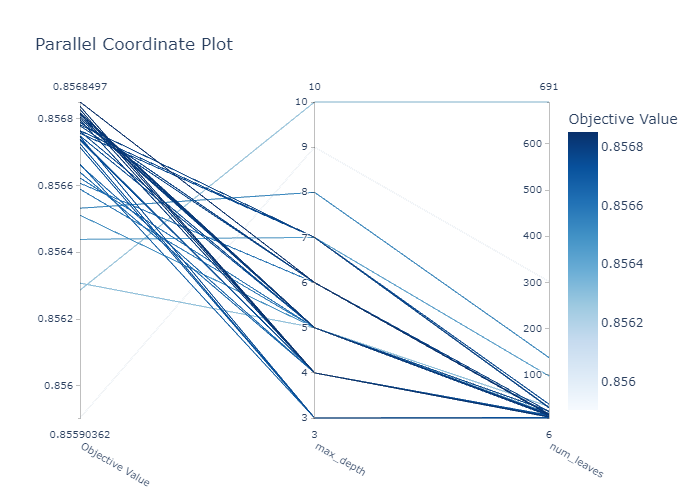

In [16]:
# Static version
img_bytes = fig.to_image(format="png", engine="kaleido")
Image(img_bytes)

# Best 10 Trials

In [17]:
data = study.trials_dataframe(attrs=('value','duration','params'))
data.columns = [x[7:] if x.startswith('params') else x for x in data.columns]
data = data.sort_values('value', ascending = False).head(10)
data

,value,duration,cat_l2,cat_smooth,colsample_bytree,learning_rate,max_depth,min_child_samples,min_child_weight,min_split_gain,num_leaves,reg_alpha,reg_lambda,subsample,subsample_freq
16,0.856850,0 days 00:11:55.428649,1.617756e-06,0.000637,0.24,0.01,6,3170,0.000826,0.762450,13,2.897981e-10,0.000185,0.86,3
14,0.856837,0 days 00:11:33.357585,9.299195e-07,0.000260,0.24,0.01,4,2020,0.002235,0.000006,9,1.439069e-10,0.000055,0.72,2
21,0.856827,0 days 00:11:07.648883,5.360472e-09,1.143732,0.29,0.01,4,2500,0.055865,6.622614,9,1.766879e-09,0.000105,0.71,1
33,0.856817,0 days 00:10:39.434412,3.429444e-07,0.347156,0.22,0.01,5,1550,8.195090,0.098115,13,3.666228e-09,0.003417,0.77,3
34,0.856816,0 days 00:09:59.582878,1.679809e-05,0.342261,0.18,0.01,5,1490,0.120237,0.127128,13,5.754832e-09,0.005372,0.78,3
31,0.856814,0 days 00:11:26.738483,4.191943e-07,16.551222,0.28,0.01,4,2410,7.304877,2.469756,9,7.731098e-10,0.000017,0.70,2
41,0.856812,0 days 00:09:36.737838,3.638505e-05,0.204013,0.18,0.01,5,1460,0.080249,0.197478,13,5.122671e-09,0.004593,0.77,3
43,0.856805,0 days 00:10:21.147088,1.188142e-04,0.069934,0.23,0.01,5,1230,0.002390,0.001852,11,2.539851e-10,0.001100,0.68,5
45,0.856800,0 days 00:09:28.050639,2.111257e-07,2.038374,0.20,0.01,5,590,0.207653,0.764936,14,1.070581e-10,0.000276,0.65,4
13,0.856795,0 days 00:11:22.007829,3.884831e-07,74.879779,0.26,0.01,4,2170,0.669597,2.012395,8,8.433165e-10,0.000037,0.70,2


In [18]:
data.describe()

,value,duration,cat_l2,cat_smooth,colsample_bytree,learning_rate,max_depth,min_child_samples,min_child_weight,min_split_gain,num_leaves,reg_alpha,reg_lambda,subsample,subsample_freq
count,10.000000,10,1.000000e+01,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000,10.000000
mean,0.856817,0 days 00:10:45.013428400,1.759121e-05,9.557737,0.232000,1.000000e-02,4.700000,1859.000000,1.663902,1.305673,11.200000,1.872179e-09,0.001516,0.734000,2.800000
std,0.000017,0 days 00:00:51.819001411,3.746453e-05,23.506898,0.038239,1.828559e-18,0.674949,741.821332,3.220603,2.059986,2.250926,2.169536e-09,0.002108,0.061137,1.135292
min,0.856795,0 days 00:09:28.050639,5.360472e-09,0.000260,0.180000,1.000000e-02,4.000000,590.000000,0.000826,0.000006,8.000000,1.070581e-10,0.000017,0.650000,1.000000
25%,0.856807,0 days 00:10:04.973930500,3.543290e-07,0.103454,0.205000,1.000000e-02,4.000000,1467.500000,0.015759,0.105368,9.000000,2.629384e-10,0.000068,0.700000,2.000000
50%,0.856815,0 days 00:10:53.541647500,6.745569e-07,0.344708,0.235000,1.000000e-02,5.000000,1785.000000,0.100243,0.479964,12.000000,8.082131e-10,0.000230,0.715000,3.000000
75%,0.856825,0 days 00:11:25.555819500,1.300300e-05,1.814714,0.255000,1.000000e-02,5.000000,2350.000000,0.554111,1.700531,13.000000,3.191391e-09,0.002838,0.770000,3.000000
max,0.856850,0 days 00:11:55.428649,1.188142e-04,74.879779,0.290000,1.000000e-02,6.000000,3170.000000,8.195090,6.622614,14.000000,5.754832e-09,0.005372,0.860000,5.000000
